<a href="https://colab.research.google.com/github/tsangrebecca/BloomTech/blob/main/Sprint5/Module4/JDS_SHR_213_guided_project_notes_PipelineAndHyperparameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BloomTech Data Science

---


# Ridge Regression
- Do one-hot encoding of categorical features
- Use scikit-learn to fit Ridge Regression models



In [1]:
!pip install category_encoders==2.*

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.4 MB/s eta 0:00:00


In [3]:
# Model Building
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For encoding categorical data
from category_encoders import OneHotEncoder

In [4]:
DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'

# I. Wrangle Data

Create **wrangle function** for **reproducibility**.

In [7]:
def wrangle(filepath):
  df = pd.read_csv(filepath,
                   parse_dates=['created'],
                   index_col='created').sort_index()

  # Remove outlier observations
  df = df[(df['price'] >= np.percentile(df['price'], 0.5)) &
          (df['price'] <= np.percentile(df['price'], 99.5)) &
          (df['latitude'] >= np.percentile(df['latitude'], 0.05)) &
          (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
          (df['longitude'] >= np.percentile(df['longitude'], 0.05)) &
          (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

  # Drop high-cardinality categorical variables
  cutoff = 5
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  return df

df = wrangle(DATA_PATH+'apartments/renthop-nyc.csv')

In [ ]:
# threshold = 10
# cols_to_drop = []
# for col in df:
#   if df[col].dtype == 'object':
#     if df[col].nunique() > threshold:
#       cols_to_drop.append(col)

# df.drop(columns=cols_to_drop, inplace=True)

In [8]:
df.head()

,bathrooms,bedrooms,latitude,longitude,price,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,...,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,
2016-04-01 22:12:41,1.0,1,40.7302,-73.9924,3195,high,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:56:00,1.0,0,40.7576,-73.9677,2000,medium,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:57:15,2.0,3,40.7388,-73.9851,5850,high,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
2016-04-01 23:26:07,1.0,1,40.7939,-73.9738,2745,medium,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
2016-04-02 00:48:13,1.0,1,40.7784,-73.9491,2400,medium,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


# II. Split Data

Split **target vector** from **feature matrix**.

In [10]:
target = 'price'
y = df[target]
X = df.drop(columns=target)

Split data into **training** and **test** sets.

(Use data from April & May 2016 to train. Use data from June 2016 to test.)

In [11]:
X.index.max(), X.index.min()

(Timestamp('2016-06-29 21:41:47'), Timestamp('2016-04-01 22:12:41'))

In [ ]:
# Several masks to choose from

# mask =
# mask =


In [12]:
# or apply the mask based on cut-off given below
cutoff = '2016-06-01'

mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [13]:
X_train.shape, y_train.shape

((31844, 29), (31844,))

In [14]:
X_test.shape, y_test.shape

((16973, 29), (16973,))

# III. Establish Baseline

In [15]:
y_pred = [y_train.mean()] * len(y_train)
print('Mean price:', y_train.mean())
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Mean price: 3575.604007034292
Baseline MAE: 1201.8811133682555


# IV. Build Models

We're going to use pipeline now that includes OneHotEncoder and Ridge

In [16]:
# # Step 1: Import your transformer class
# # We did above ☝️

# # Step 2: Insantiate your transformer
# ohe = OneHotEncoder(use_cat_names=True)

# # Step 3: Fit your transformer
# ohe.fit(X_train)

# # Step 4: Transform
# XT_train = ohe.transform(X_train)
# XT_test = ohe.transform(X_test)


**Model 1:** Regular ol' linear regression

In [18]:
model_lr = LinearRegression()
model_lr.fit(XT_train, y_train)

LinearRegression()

**Model 2:** Ridge regression (regularization)

In [19]:
# model_r = Ridge(alpha=1.0)
# model_r.fit(XT_train, y_train)

Ridge()

Create the pipeline (we don't have to create a new dataframe called XT_train anymore)

In [26]:
model_r = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge(alpha=1.0)
)

model_r.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['interest_level'], use_cat_names=True)),
                ('ridge', Ridge())])

# V. Check Metrics

In [ ]:
# print('LR training MAE:', mean_absolute_error(y_train, model_lr.predict(XT_train)))
# print('LR test MAE:', mean_absolute_error(y_test, model_lr.predict(XT_test)))

In [22]:
print('Ridge training MAE:', mean_absolute_error(y_train, model_r.predict(X_train)))
print('Ridge test MAE:', mean_absolute_error(y_test, model_r.predict(X_test)))

Ridge training MAE: 672.664072658999
Ridge test MAE: 675.5149089564139


# Communicate results

In [ ]:
# coefficients =
# features =

# feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
# feat_imp.tail().plot(kind='barh')

# plt.xlabel('Coefficient [$]')
# plt.ylabel('Feature')
# plt.title('Coefficients for Linear Regression');

/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


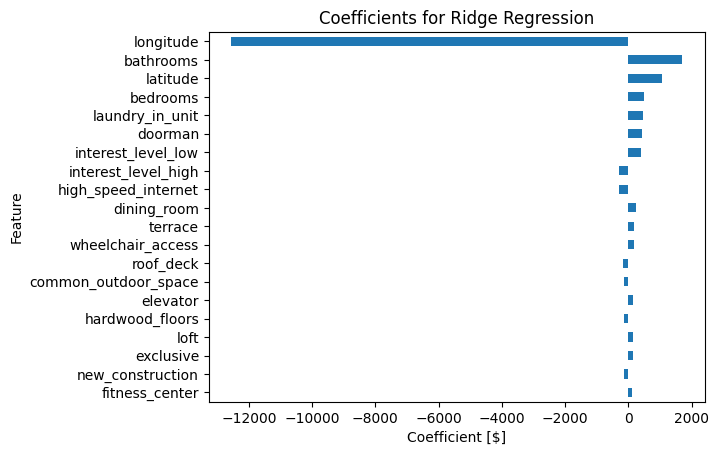

In [28]:
# you can't call coef_ directly because now we have a pipeline that consists of the model, can't access the model directly for coefficients
coefficients = model_r.named_steps['ridge'].coef_    # with pipeline, we now have to type .name_steps['name of step']
features = model_r.named_steps['onehotencoder'].get_feature_names()  # the step name has to be all lower case!!!!

feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(20).plot(kind='barh')

plt.xlabel('Coefficient [$]')
plt.ylabel('Feature')
plt.title('Coefficients for Ridge Regression');


In [ ]:
# import seaborn as sns
# sns.set(rc={'figure.figsize':(15,15)})
# sns.scatterplot('longitude', 'latitude', hue='price', data=df);


##VI. Tune Model

** Interlude: How do you know what the best hyperparameter values are?**

- model parameters are coefficients and intercept - numbers derived from trainin the model
- model hyperparameters are values specified outside of the model, the training, e.g. the alpha value in Ridge regression. Linear Regression has no hyperparameters.
- best hyperparameters are values that give the best predictions from the model

In [31]:
alphas = np.arange(1.0, 20.5, 0.5)

train_mae = []
test_mae = []

for a in alphas:
  model_r = make_pipeline(
      OneHotEncoder(use_cat_names=True),
      Ridge(alpha=a)
  )

  model_r.fit(X_train, y_train)
  train_mae.append(mean_absolute_error(y_train, model_r.predict(X_train)))
  test_mae.append(mean_absolute_error(y_test, model_r.predict(X_test)))

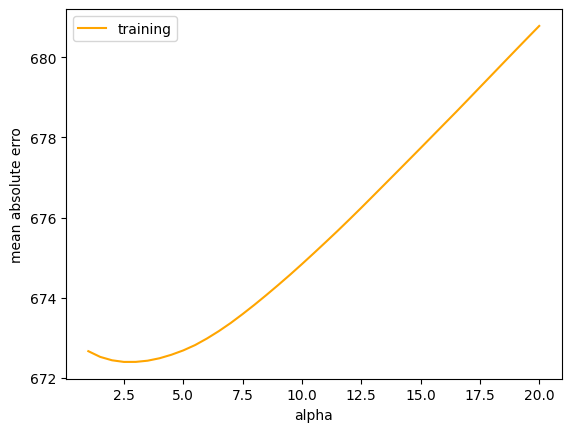

In [34]:
plt.plot(alphas, train_mae, color='orange', label= 'training')
# plt.plot(alphas, test_mae, color='blue', label= 'test') # don't look at test set, because can cause data scientist-induced bias
plt.xlabel('alpha')
plt.ylabel('mean absolute erro')
plt.legend();

# but just looking at training set is also not a good predictor whether the model will generalize unseen data well, that's why we need validation data set!